<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2024_hands_on/blob/main/Week08_Image_Classification_Competition_with_Google_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 08

## Introduction
Training of CNN models usually takes a lot of time. If you are using a free version of GPU runtime (T4) on Google Colab for model training, you can easily reach the usage limit.

One of the solutions to deal with this issue is to leverage Google Drive during training. This notebook demonstrates how to store your dataset and trained model weights to your Google Drive, particularly useful for the image classification competition.

## Setup

### GPU

Please make sure your runtime type is set to GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

### General Packages

Let's import some general Python packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import gdown

### Working Directory in Your Google Drive

You need to create a working directory within your Google Drive manually. You are free to name this directory as you prefer. In this notebook, we will be using a working directory named `noodles_competition`, located within your `My Drive` folder.

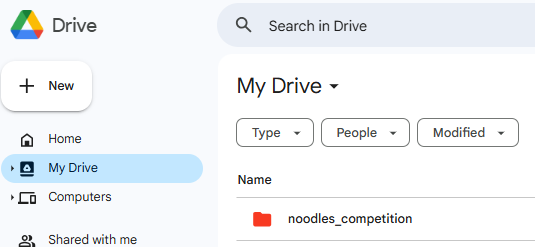

### Mount Google Drive

Now let's mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Access to Working Directory

You can check if you have access to the working directory.

In [ ]:
working_dir = "/content/drive/MyDrive/noodles_competition"

print(f"Can access to {working_dir}?")
print(os.path.exists(working_dir))

## Data Preparation

### Download Data

You can download `dataset2024.zip` to your working directory within Google Drive. This zip file will not be deleted even after you close this Google Colab session.

In [ ]:
dataset_zip_path = os.path.join(working_dir, "dataset2024.zip")
url = "https://drive.google.com/uc?id=1rwHm543Ugf8B3wwvGEcLkIDgAWOYnl4J"

if not os.path.exists(dataset_zip_path):
    gdown.download(url, dataset_zip_path, quiet=False)
    print(f"Download completed! {dataset_zip_path}")
else:
    print(f"File already exists. {dataset_zip_path}")

Then unzip `dataset2024.zip` then you will find `dataset2024` directory in the Files tab.

In [ ]:
! unzip $dataset_zip_path  > /dev/null 2>&1

In the `dataset2024` directory, you will find two main directories named `train` and `test`. Within the `train` directory, there are subdirectories labeled `0_spaghetti`, `1_ramen`, and `2_udon`, each containing respective images of spaghetti, ramen, and udon. Inside the `test` directory, there is a subdirectory named `unknown`, which contains spaghetti, ramen, and udon images mixed together in a random order.

Let's check how many image data we have.

In [ ]:
for subdir in ["train", "test"]:
    print(subdir)
    subsubdirs = sorted(os.listdir(os.path.join("dataset2024", subdir)))
    for subsubdir in subsubdirs:
        filenames = os.listdir(os.path.join("dataset2024", subdir, subsubdir))
        print("---", subsubdir, ":", len(filenames))
        for filename in filenames[:5]:
            print("    ---", filename)

### Create Dataset
To create PyTorch datasets with this tree-structured directory format, we can use `torchvision.datasets.ImageFolder` class.

In [ ]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root="dataset2024/train")
test_dataset = ImageFolder(root="dataset2024/test")

print("train_dataset:", len(train_dataset))
print("test_dataset:", len(test_dataset))

Here, we are creating a dictionary to map the class names.

In [ ]:
classnames = {0:"spaghetti", 1:"ramen", 2:"udon"}
classnames

Now we can create the dataset objects.

In [ ]:
from torchvision.transforms import v2

train_dataset = ImageFolder(root="dataset2024/train",
                            transform=v2.Compose([
                                v2.Resize((96, 96)),
                                v2.ToTensor()
                                ])
                            )

test_dataset = ImageFolder(root="dataset2024/test",
                           transform=v2.Compose([
                                v2.Resize((96, 96)),
                                v2.ToTensor()
                                ])
                            )

### Data Splitting

We split the original training dataset into new training and validation datasets.

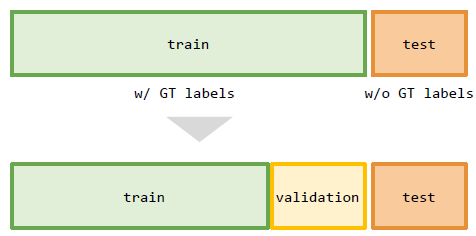

In [ ]:
from torch.utils.data import random_split

n_samples = len(train_dataset)
train_size = int(n_samples * 0.5)    # 50% will be training data
valid_size = n_samples - train_size  # 50% will be validation data

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("train data", len(train_dataset))
print("validation data", len(valid_dataset))

### DataLoader

Then we create the dataloaders for the training, validation and test dataset.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

## Model Building

### Model Architecture

You can use any kind of models you want.

In [ ]:
import torch.nn as nn

# define a class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change

        # define a network module named "features"
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # define a network module named "junction"
        self.junction = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(8, 8)),
            nn.Flatten()
        )

        # define a network module named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*8*8, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10)
        )

    # Instance method
    def forward(self, x):   # do not change
        x = self.features(x)
        x = self.junction(x)
        x = self.classifier(x)
        return x

model = Model()    # construct an instance of the Model class
print(model)

## Training

### Save Model in Google Drive

You can save your model weights in your working directory at any time. Please refer [the notebook on Week6](https://github.com/naoya1110/ai_robotics_lab_2024_hands_on/blob/main/Week06_Practical_Techniques_for_Training_CNN.ipynb)

In [ ]:
# save the model weights
model_path = os.path.join(working_dir, "my_model.pth")
torch.save(model.state_dict(), model_path)

### Training Loop







In [ ]:
import torch.optim as optim

model = Model().to(device)                             # load model to GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 10

experiment_name = "experiment1"


# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    valid_correct_count = 0
    valid_accuracy = 0
    valid_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(valid_loader)
        pbar.set_description("Valid")

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            valid_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            valid_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    valid_accuracy = valid_correct_count.item()/len(valid_dataset)   # determin accuracy for test data
    train_loss = train_loss/len(train_loader)       # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)       # determin loss for validation data

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)

    # save model weights
    model_path = os.path.join(working_dir, f"model_{experiment_name}_ep{epoch+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    print("---------------------")

### Learning Curves

Let's visualize the accuracy and the loss curves for training and validation data.

In [ ]:
plt.figure(figsize=(5, 3))
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Submission

### Load Your Model
You can load the model weights from any saved checkpoints.

In [ ]:
best_model_path = os.path.join(working_dir, f"model_experiment1_ep10.pth")

model = Model().to(device)                           # load an initialized model
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

### Make Submission File

In [ ]:
#####################
##  DO NOT CHANGE  ##
#####################

p_label_all = np.array([])

with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        p_batch = model(x_batch)
        p_batch_label = torch.argmax(p_batch, dim=1)
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())

p_label_all = p_label_all.astype("uint8")
print(p_label_all)

df_submit = pd.DataFrame()
df_submit["ID"] = np.arange(4500)
df_submit["Target"] = p_label_all

submission_filepath = os.path.join(working_dir, f"your_submission_{experiment_name}.csv")
df_submit.to_csv(submission_filepath, index = False)

df_submit

## Conclusion

That's it for this week. Try your best for the image classification competition!